<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/CIDL2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from matplotlib import pyplot as plt

train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [ ]:
class CNNClassifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = torch.nn.Sequential(
       torch.nn.Conv2d(1,32, (5,5), padding=1),
       torch.nn.ReLU(),
       torch.nn.Conv2d(32,64,(5,5),stride=2,padding = 0),
       torch.nn.ReLU(),
       torch.nn.MaxPool2d((2,2), stride = 2),
       torch.nn.Conv2d(64,64,(3,3), stride = 2)
    )

    self.ff = torch.nn.Sequential(
        torch.nn.Linear(256,300),
        torch.nn.ReLU(),
        torch.nn.Linear(300,300),
        torch.nn.ReLU(),
        torch.nn.Linear(300,10),
        torch.nn.Softmax(dim=1)
    )

  def forward(self, x):
    features = self.cnn(x)
    features = features.view(features.shape[0], -1)
    prob = self.ff(features)
    return prob

dl = torch.utils.data.DataLoader(train_mnist, batch_size = 8, shuffle=True)
cnn = CNNClassifier()

digits,classes = next(iter(dl))
out = cnn(digits)
print(out.shape)


torch.Size([8, 10])


In [ ]:
from tqdm import tqdm
dl = torch.utils.data.DataLoader(train_mnist, batch_size=32,shuffle=True)
model = CNNClassifier()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model = model.to('cuda')
for epoch in range(3):
  bar = tqdm(dl)
  for digit, classes in bar:
    digit = digit.to('cuda')
    classes = classes.to('cuda')
    pred = model(digit)
    loss = loss_fn(pred,classes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    accuracy = (pred.argmax(dim=1) == classes).float().mean()
    bar.set_description(f"Loss {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

Loss 1.4943, Accuracy: 0.9688: 100%|██████████| 1875/1875 [00:27<00:00, 68.92it/s]


# Esercizio 2

In [ ]:
class PointsDataset(torch.utils.data.Dataset):

  def __init__(self,dataset):
    self.points = dataset

  def __len__(self):
    return len(self.points)

  def __getitem__(self,i):
      digit, cls = self.points[i]
      vector = torch.zeros(10)
      vector[cls] = 1
      return vector,digit

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.ff = torch.nn.Sequential(
        torch.nn.Linear(10,300),
        torch.nn.ReLU(),
        torch.nn.Linear(300,300),
        torch.nn.ReLU(),
        torch.nn.Linear(300,784)
    )

  def forward(self, x):
    features = self.ff(x)
    features = features.view([-1,1,28,28])
    return features

In [ ]:
from tqdm import tqdm
ds = PointsDataset(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32,shuffle=True)
model = MLP()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model = model.to('cuda')
for epoch in range(3):
  bar = tqdm(dl)
  for classes, digit in bar:
    digit = digit.to('cuda')
    classes = classes.to('cuda')
    pred = model(classes)
    loss = loss_fn(pred,digit)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    bar.set_description(f"Loss {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

Loss 0.5721, Accuracy: 0.9688: 100%|██████████| 1875/1875 [00:24<00:00, 76.38it/s]


tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


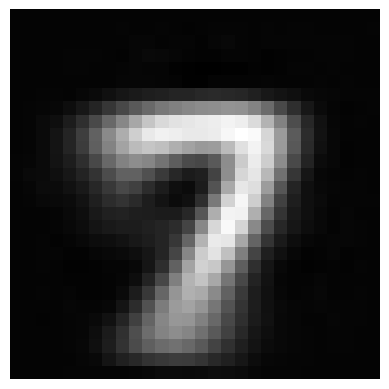

In [ ]:
import matplotlib.pyplot as plt

ds_test = PointsDataset(test_mnist)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=32)

label, batch_digit = next(iter(dl_test))

digit_ohe = label
y_pred = model(digit_ohe.to("cuda"))

print(digit_ohe[0])
image = y_pred[0]


image = image.to("cpu").detach().numpy()
plt.imshow(image[0], cmap='gray')  # 'cmap' specifies that it's a grayscale image
plt.axis('off')  # Turn off the axis
plt.show()

# Esercizio 3

In [ ]:
import random
class FollowingNumberDataset(torch.utils.data.IterableDataset):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def __iter__(self):
    return self

  def __next__(self):
    a_digit, a_class = random.choice(self.dataset)
    while a_class == 9:
      a_digit, a_class = random.choice(self.dataset)
    b_digit, b_class = random.choice(self.dataset)
    while b_class != a_class +1:
      b_digit, b_class = random.choice(self.dataset)

    return a_digit, b_digit

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                out_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
        )

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=1
                ),
                torch.nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)

        if self.downsample is not None:
            out = self.downsample(x) + y
        else:
            out = x + y

        return torch.relu(out)


class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            ResidualBlock(1, 16),
            ResidualBlock(16, 32),
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 32),
            ResidualBlock(32, 16),
            ResidualBlock(16, 1),
        )

    def forward(self, x):
        y = self.net(x)
        return y

ds = FollowingNumberDataset(train_mnist)
model = ResNet()

for a, b in ds:
    out = model(a.unsqueeze(0))
    print(out.shape)
    break

torch.Size([1, 1, 28, 28])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss 0.6893: 100%|██████████| 1000/1000 [01:31<00:00, 10.94it/s]


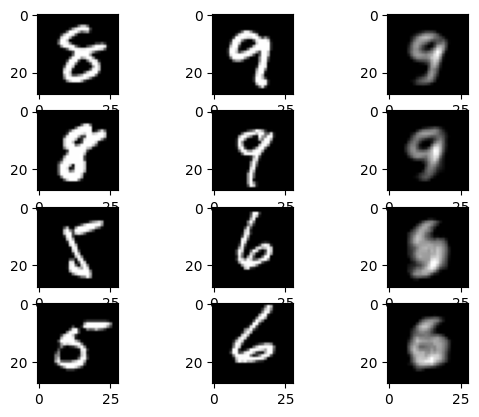

0.6892640590667725


Loss 0.6555: 100%|██████████| 1000/1000 [01:28<00:00, 11.31it/s]


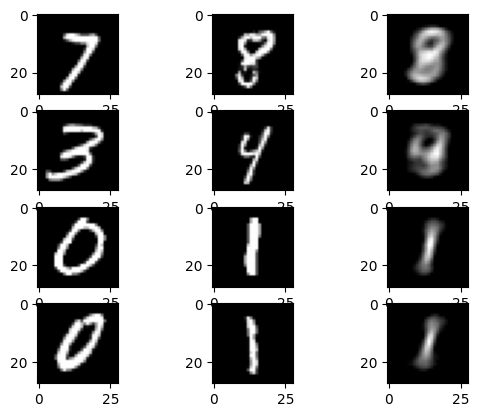

0.655487060546875


Loss 0.6719: 100%|██████████| 1000/1000 [01:27<00:00, 11.44it/s]


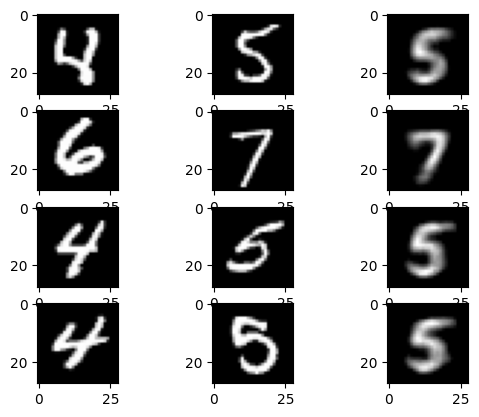

0.6718829274177551


In [ ]:
from tqdm import trange, tqdm
from matplotlib import pyplot as plt

batches = 1000
ds = FollowingNumberDataset(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=8)
model = ResNet()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to("cuda")

for epoch in range(3):
    bar = tqdm(enumerate(dl), total=batches)
    for i, (a, b) in bar:
        a = a.to("cuda")
        b = b.to("cuda")

        optimizer.zero_grad()
        out = model(a)
        loss = loss_fn(out, b)

        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss {loss.item():.4f}")

        if i >= batches:
            break

    fig, axes = plt.subplots(4, 3)
    for i in range(0, 4):
        axes[i, 0].imshow(a[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[i, 1].imshow(b[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[i, 2].imshow(out[i].detach().cpu().numpy().squeeze(), cmap="gray")
    plt.show()

    print(loss.item())

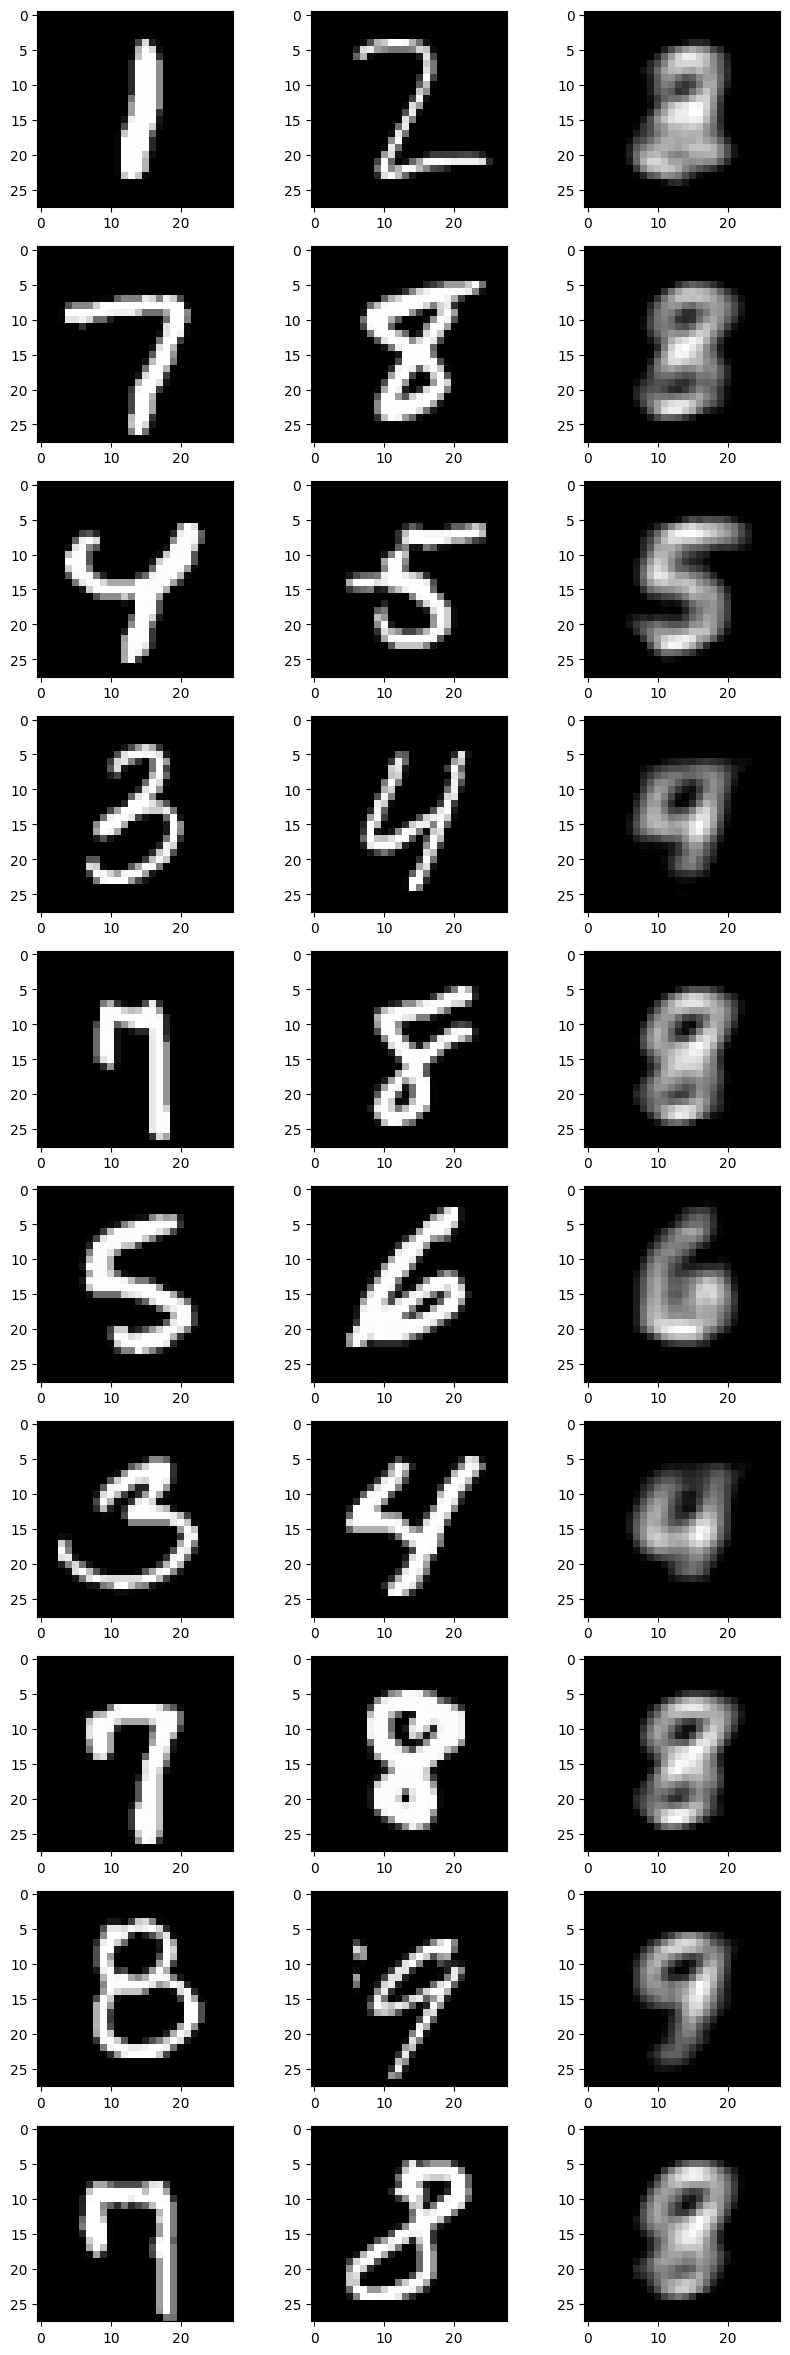

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

ds = FollowingNumberDataset(test_mnist)

fig, axes = plt.subplots(10, 3, figsize=(10, 30))

for i, (a, b) in zip(range(0, 10), ds):
    a = a.to("cuda")
    b = b.to("cuda")
    out = model(a.unsqueeze(0))

    axes[i, 0].imshow(a[0].cpu().numpy(), cmap="gray")

    axes[i, 1].imshow(b[0].cpu().numpy(), cmap="gray")
    axes[i, 2].imshow(out[0, 0].detach().cpu().numpy(), cmap="gray")

plt.show()